In [1]:
zero_frac = 0.25
m_frac = 0.6
p_frac = 0.6
correction = 0.2
top_crop, bottom_crop, left_crop, right_crop = 60, 25, 0, 0
layers = 2
BATCHES = 32
EPOCHS = 5

## Build Log

In [2]:
import pandas as pd
%matplotlib inline

In [30]:
driving_log = pd.read_csv('data/driving_log_1.csv', usecols=['center', 'left', 'right', 'steering'])
driving_log.shape

(8036, 4)

In [31]:
driving_log.head()

,center,left,right,steering
0,data/data/IMG/center_2016_12_01_13_30_48_287.jpg,data/data/IMG/left_2016_12_01_13_30_48_287.jpg,data/data/IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,data/data/IMG/center_2016_12_01_13_30_48_404.jpg,data/data/IMG/left_2016_12_01_13_30_48_404.jpg,data/data/IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,data/data/IMG/center_2016_12_01_13_31_12_937.jpg,data/data/IMG/left_2016_12_01_13_31_12_937.jpg,data/data/IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,data/data/IMG/center_2016_12_01_13_31_13_037.jpg,data/data/IMG/left_2016_12_01_13_31_13_037.jpg,data/data/IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,data/data/IMG/center_2016_12_01_13_31_13_177.jpg,data/data/IMG/left_2016_12_01_13_31_13_177.jpg,data/data/IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [32]:
driving_log['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

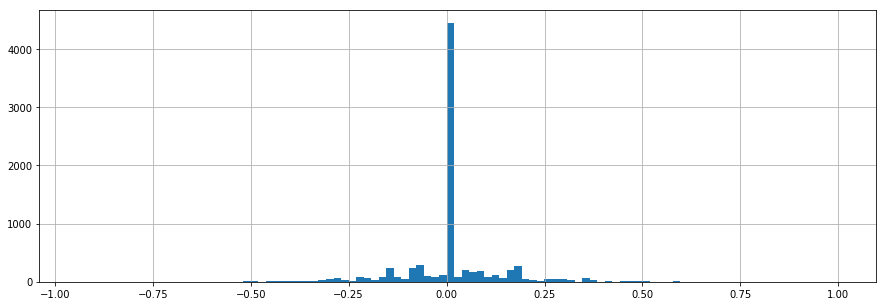

In [33]:
_ = driving_log['steering'].hist(bins=101, figsize=(15,5))

In [11]:
def undersample(log, value, frac):
    log_nonvalue = log[log['steering']!=value]
    log_value = log[log['steering']==value]
    
    if len(log_value)>0:
        log_value = log_value.sample(frac=frac)
    
    log = log_value.append(log_nonvalue)
    log = log.reset_index(drop=True)
    return log

In [12]:
driving_log = undersample(driving_log, 0, zero_frac)
driving_log = undersample(driving_log, -1, m_frac)
driving_log = undersample(driving_log, 1, p_frac)

In [13]:
driving_log['steering'].describe()

count    4764.000000
mean        0.006655
std         0.166664
min        -0.942695
25%        -0.069252
50%         0.000000
75%         0.090466
max         1.000000
Name: steering, dtype: float64

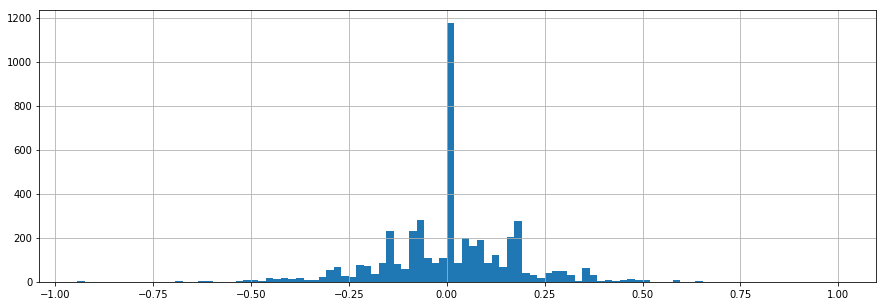

In [14]:
_ = driving_log['steering'].hist(bins=101, figsize=(15,5))

In [15]:
# Build new log taking into account correction for left and right camera images 
def augment_left_right(driving_log, correction):
    log = pd.DataFrame({'image':driving_log['center']
                                .append(driving_log['left'])
                                .append(driving_log['right']),
                        'steering':driving_log['steering']
                                .append(driving_log['steering'] + correction)
                                .append(driving_log['steering'] - correction)})

    #log = log[(log['steering']>=-1)&(log['steering']<=1)]
    return log

In [16]:
log = augment_left_right(driving_log, correction)

log.head()

,image,steering
0,data/IMG/center_2016_12_01_13_38_42_894.jpg,1.0
1,data/IMG/center_2016_12_01_13_37_54_135.jpg,0.0
2,data/IMG/center_2016_12_01_13_46_36_163.jpg,0.0
3,data/IMG/center_2016_12_01_13_38_12_425.jpg,0.0
4,data/IMG/center_2016_12_01_13_43_32_370.jpg,0.0


In [17]:
log['steering'].describe()

count    14292.000000
mean         0.006655
std          0.233327
min         -1.142695
25%         -0.176514
50%          0.000000
75%          0.187715
max          1.200000
Name: steering, dtype: float64

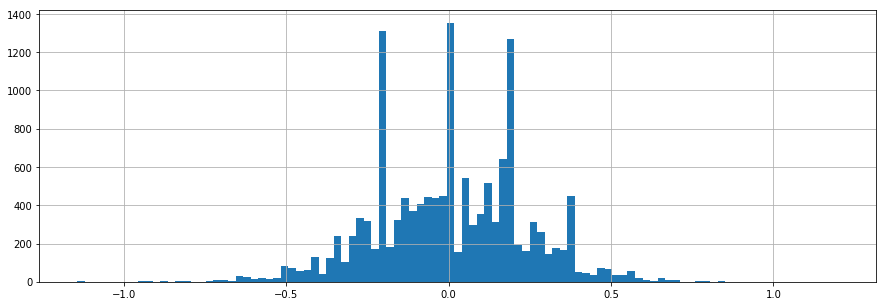

In [18]:
_ = log['steering'].hist(bins=101, figsize=(15,5))

In [19]:
# Shuffle final log DataFrame
log = log.sample(frac=1).reset_index(drop=True)  

## Build Training and Validation Data

In [20]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D

from sklearn.model_selection import train_test_split
import sklearn
%matplotlib inline

Using TensorFlow backend.


In [21]:
# Train / Validation split
train_log, validation_log = train_test_split(log, test_size=0.2)

train_log = train_log.reset_index(drop=True)
validation_log = validation_log.reset_index(drop=True)

log.shape, train_log.shape, validation_log.shape

((14292, 2), (11433, 2), (2859, 2))

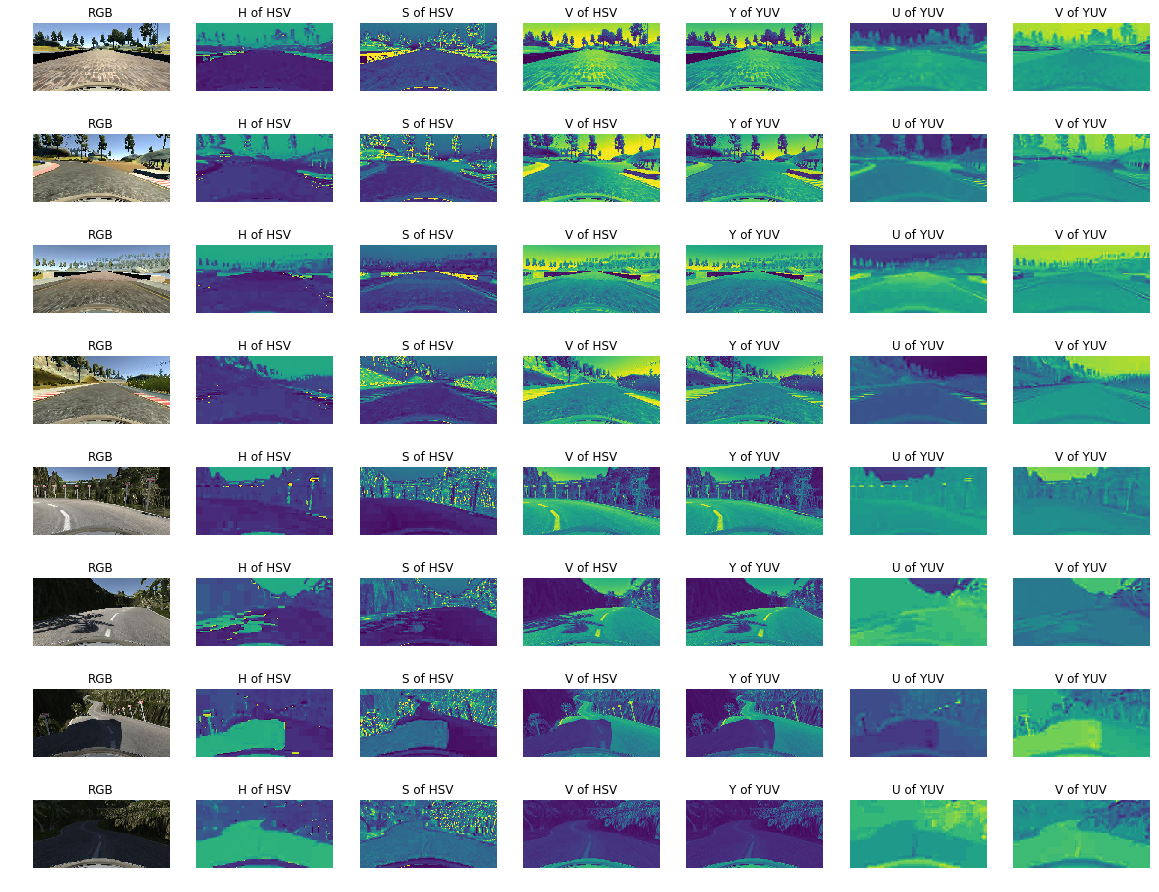

In [22]:
# Plotting typical images in HSV and YUV color spaces
import glob

images = glob.glob('examples\Track1\*.*') + glob.glob('examples\Track2\*.*')

fig, axs = plt.subplots(8, 7, figsize=(20, 2*8))
    
i = 0    
for i in range(8):
    filename = images[i]
    image = mpimg.imread(filename)
    axs[i,0].axis('off')
    axs[i,0].imshow(image)
    axs[i,0].set_title('RGB') 

    axs[i,1].axis('off')
    axs[i,1].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,0])
    axs[i,1].set_title('H of HSV') 
    
    axs[i,2].axis('off')
    axs[i,2].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1])
    axs[i,2].set_title('S of HSV') 
    
    axs[i,3].axis('off')
    axs[i,3].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,2])
    axs[i,3].set_title('V of HSV') 
    
    axs[i,4].axis('off')
    axs[i,4].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0])
    axs[i,4].set_title('Y of YUV') 

    axs[i,5].axis('off')
    axs[i,5].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,1])
    axs[i,5].set_title('U of YUV') 
   
    axs[i,6].axis('off')
    axs[i,6].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,2])
    axs[i,6].set_title('V of YUV') 


In [23]:
# Image preprocessing (except normalization and cropping that are done in CNN layers)
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1:]
    
    return image

In [24]:
# Get X,y from the log. Augmentation with flipped images is applied
def get_data(log):    
    images = []
    steerings = []
    
    for _, row in log.iterrows():
        filename = row['image'].strip()
        image = preprocess(mpimg.imread(filename))
        image_flip = cv2.flip(image, 1)
        if layers==1:
            image_flip = image_flip[:,:,None]
        
        steering = row['steering']

        images.extend([image, image_flip])
        steerings.extend([steering, -steering])

    X, y = np.array(images), np.array(steerings)
    X, y = sklearn.utils.shuffle(X, y)
    
    return X, y

In [25]:
def generator(sample_log, batch_size):
    n_rows = len(sample_log)
    while 1: # Loop forever so the generator never terminates
        sample_log = sample_log.sample(frac=1).reset_index(drop=True)  #shuffle sample_log DataFrame
        
        for offset in range(0, n_rows, batch_size):
            batch_log = sample_log[offset : offset + batch_size]

            X, y = get_data(batch_log)
            
            yield X, y 

In [26]:
# Train and Validation generators
train_generator = generator(train_log, batch_size=BATCHES)
validation_generator = generator(validation_log, batch_size=BATCHES)

## Compile and train the model

In [27]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,layers)))
model.add(Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)), input_shape=(160,320,layers)))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_log),
                                     validation_data = validation_generator, 
                                     nb_val_samples=len(validation_log),
                                     nb_epoch=EPOCHS,
                                     verbose=1)

model.save('model.h5')

Epoch 1/5
11392/11433 [============================>.] - ETA: 0s - loss: 0.0253  

C:\Users\ETASMAK\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


11456/11433 [==============================] - 233s - loss: 0.0252 - val_loss: 0.0194
Epoch 2/5
11474/11433 [==============================] - 234s - loss: 0.0205 - val_loss: 0.0199

dict_keys(['loss', 'val_loss'])


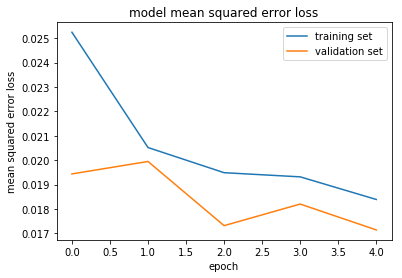

In [28]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [29]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: cannot import name 'plot_model'

In [ ]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))